In [1]:
! pip install lightfm
! pip install shap
! pip install rectools
! pip install tools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.1/310.1 KB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.16-cp38-cp38-linux_x86_64.whl size=746155 sha256=44f7854812a3f1b51f1dc6252d844e2190b5f4c908a2eb4501bb6ddc7ecb1262
  Stored in directory: /root/.cache/pip/wheels/ec/bb/51/9c487d021c1373b691d13cadca0b65b6852627b1f3f43550fa
Successfully built lightfm
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 15.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import warnings
warnings.simplefilter('ignore')

import dill
import numpy as np
import pandas as pd
import requests
import shap
import tools

from lightfm import LightFM
from lightfm.data import Dataset
from lightgbm import LGBMRanker, LGBMClassifier
from rectools.metrics import calc_metrics, NDCG, MAP, Precision, Recall, MeanInvUserFreq
from rectools import Columns
from rectools.dataset import Dataset
from rectools.models import ImplicitALSWrapperModel, LightFMWrapperModel
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from typing import Any, Dict, Tuple
from tqdm.auto import tqdm
from zipfile import ZipFile

In [3]:
# download dataset by chunks
url = "https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip"

req = requests.get(url, stream=True)

with open('kion_train.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [4]:
!unzip kion_train.zip

Archive:  kion_train.zip
   creating: kion_train/
  inflating: kion_train/interactions.csv  
  inflating: __MACOSX/kion_train/._interactions.csv  
  inflating: kion_train/users.csv    
  inflating: __MACOSX/kion_train/._users.csv  
  inflating: kion_train/items.csv    
  inflating: __MACOSX/kion_train/._items.csv  


In [3]:
interactions = pd.read_csv('kion_train/interactions.csv')
users = pd.read_csv('kion_train/users.csv')
items = pd.read_csv('kion_train/items.csv')

In [4]:
interactions.rename(
    columns={
        'last_watch_dt': Columns.Datetime,
        'watched_pct': Columns.Weight,
    }, 
    inplace=True,
) 
# Меняем тип данных
interactions['datetime'] = interactions['datetime'].astype(np.datetime64)

# Заполняем пропуски
interactions_default_values: Dict[str, Any] = {
   Columns.Datetime: interactions[Columns.Datetime].median(),
    Columns.Weight: 0.,
    'total_dur': 0,
}
interactions.fillna(interactions_default_values, inplace=True)

In [5]:
interactions.head()

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [6]:
def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {} 

    for col in cat_cols:
        cat_col = df[col].astype('category').cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype('category')
    return df, cat_col_encoding

users_cat_cols = [
     'age', 'income', 'sex', 'kids_flg'
]
users, users_cat_col_encoding = encode_cat_cols(users, users_cat_cols)

# None уже кодируется как -1
users_cat_col_encoding['income'], users['income'].unique()

(Index(['income_0_20', 'income_150_inf', 'income_20_40', 'income_40_60',
        'income_60_90', 'income_90_150'],
       dtype='object'), [4, 2, 3, 0, -1, 5, 1]
 Categories (7, int64): [-1, 0, 1, 2, 3, 4, 5])

In [7]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,1,4,1,1
1,962099,0,2,1,0
2,1047345,3,3,0,0
3,721985,3,2,0,0
4,704055,2,4,0,0


In [8]:
items_cat_cols = [ 
    'content_type', 'for_kids', 'studios',
]
items_text_cols = [
    'title', 'title_orig', 'genres', 'countries', 'directors', 'actors', 'description', 'keywords',
]
items_num_cols = [
    'release_year', 'age_rating', 
]
default_values_items = {
    'release_year': items['release_year'].median(),
    'age_rating': items['age_rating'].median(),
}

items, items_cat_col_encoding = encode_cat_cols(items, items_cat_cols) 
items = items.drop(items_text_cols, axis=1)
items.fillna(default_values_items, inplace=True)

items_cat_col_encoding['studios']

Index(['ABC', 'Amediateka', 'BBC', 'CBS', 'CBS All Access', 'Channel 4',
       'Cinemax', 'DAZN', 'Disney', 'Endemol', 'FX', 'Fox', 'Fremantle', 'HBO',
       'HBO Max', 'HBO, BBC', 'Legendary', 'MGM', 'New Regency Productions',
       'Paramount', 'Showtime', 'Sky', 'Sky, Fremantle', 'Sony Pictures',
       'Sony Pictures Television', 'Sony Pictures, рентв', 'Sony Plus',
       'Sony Plus, рентв', 'Starz', 'Universal', 'Universal, рентв',
       'Warner Bros', 'Warner Bros. Television', 'Ленфильм', 'Ленфильм, рентв',
       'Мосфильм', 'Рок фильм', 'рентв'],
      dtype='object')

In [9]:
items.head()

,item_id,content_type,release_year,for_kids,age_rating,studios
0,10711,0,2002.0,-1,16.0,-1
1,2508,0,2014.0,-1,16.0,-1
2,10716,0,2011.0,-1,16.0,-1
3,7868,0,2015.0,-1,16.0,-1
4,16268,0,1978.0,-1,12.0,33


In [10]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f'min дата в interactions: {min_date}')
print(f'max дата в interactions: {max_date}')
print(f'Продолжительность: {max_date - min_date}')

min дата в interactions: 2021-03-13 00:00:00
max дата в interactions: 2021-08-22 00:00:00
Продолжительность: 162 days 00:00:00


In [11]:
ranker_days_count = 30

ranker_data = interactions[
    (interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=ranker_days_count))
]

train_size = 0.7
val_size = 0.15
test_size = 0.15

train_val_users, test_users = train_test_split(
    ranker_data['user_id'].unique(), random_state=42, test_size=test_size
)

train_users, val_users = train_test_split(
    train_val_users, random_state=42, test_size=val_size / (train_size + val_size)  # 15% от общего размера
)

In [12]:
ranker_days_count = 30
ranker_data = interactions[
    (interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))
]

In [13]:
base_models_data = interactions[
    (interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))
]

In [14]:
# Получаем длину истории юзера 
base_models_data['user_hist'] = (
    base_models_data.groupby('user_id')
    ['item_id'].transform('count')
)
# Получаем популярность контента
base_models_data['item_pop'] = (
    base_models_data.groupby('item_id')
    ['user_id'].transform('count')
)
# Получаем среднюю популярность контента, просматриваемого этим юзером
base_models_data['user_avg_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('mean')
)
# Получаем среднюю длину истории пользователя, которые смотрит этот контент
base_models_data['item_avg_hist'] = (
    base_models_data.groupby('item_id')
    ['user_hist'].transform('mean')
)
# Получаем популярность последнего просмотренного контента
base_models_data.sort_values(
    by=[Columns.User, Columns.Datetime], 
    ascending=[True, False], 
    ignore_index=True,
    inplace=True,
)
base_models_data['user_last_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('first')
)
base_models_data.head()

,user_id,item_id,datetime,total_dur,weight,user_hist,item_pop,user_avg_pop,item_avg_hist,user_last_pop
0,0,6006,2021-07-20,1,0.0,6,5208,41885.0,16.891897,5208
1,0,7102,2021-07-19,169,3.0,6,11626,41885.0,20.349475,5208
2,0,14359,2021-07-19,130,2.0,6,6053,41885.0,22.546836,5208
3,0,15297,2021-07-19,459,0.0,6,137128,41885.0,7.364295,5208
4,0,9728,2021-07-19,4,0.0,6,76978,41885.0,11.165736,5208


In [15]:
items = pd.merge(
    left=items, 
    right=(
        base_models_data
        [['item_id', 'item_pop', 'item_avg_hist']]
        .drop_duplicates()
    ),
    how='left',
    on='item_id',
)

users = pd.merge(
    left=users, 
    right=(
        base_models_data
        [['user_id', 'user_hist', 'user_avg_pop', 'user_last_pop']]
        .drop_duplicates()
    ),
    how='left',
    on='user_id',
)

In [16]:
items.head()

,item_id,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist
0,10711,0,2002.0,-1,16.0,-1,4.0,63.250000
1,2508,0,2014.0,-1,16.0,-1,9.0,75.222222
2,10716,0,2011.0,-1,16.0,-1,6.0,65.666667
3,7868,0,2015.0,-1,16.0,-1,2.0,88.000000
4,16268,0,1978.0,-1,12.0,33,1.0,28.000000


In [17]:
users.head()

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop
0,973171,1,4,1,1,5.0,19550.800000,93403.0
1,962099,0,2,1,0,13.0,1329.307692,260.0
2,1047345,3,3,0,0,NaN,NaN,NaN
3,721985,3,2,0,0,13.0,6009.461538,446.0
4,704055,2,4,0,0,7.0,531.571429,68.0


In [18]:
# Для новых фичей айтемов
default_values_items['item_pop'] = base_models_data['item_pop'].median()
default_values_items['item_avg_hist'] = base_models_data['item_avg_hist'].median()

# Для новых фичей юзеров
default_values_users = {
    'user_hist': 0,
    'user_avg_pop': base_models_data['user_avg_pop'].median(),
    'user_last_pop': base_models_data['user_last_pop'].median(),
}

In [19]:
def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame, 
    df: pd.DataFrame,
) -> pd.DataFrame:
    df = pd.merge(
        df[df['user_id'].isin(user_list)], 
        candidates_df[candidates_df['user_id'].isin(user_list)], 
        how='outer',  # right ? 
        on=['user_id', 'item_id']
    )
    min_score: float =  df['lfm_score'].min() - 0.01
    max_rank: int = df['lfm_rank'].max() + 1
    
    default_values = {
        'lfm_score': min_score,
        'lfm_rank': max_rank,
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)
        
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    return df

In [20]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(
        df, 
        users, 
        how='left', 
        on=['user_id']
    )
    df = pd.merge(
        df, 
        items, 
        how='left', 
        on=['item_id']
    )

    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df

In [21]:
candidates = pd.read_csv('/content/drive/MyDrive/lfm_candidates.csv').rename(
      columns={'rank': 'lfm_rank', 'score': 'lfm_score'}
    )
candidates = candidates[candidates['lfm_rank'] < 50]

In [22]:
candidates.head()

,user_id,item_id,lfm_score,lfm_rank
0,176549,10440,-358.234079,1
1,176549,4151,-359.700495,2
2,176549,13865,-360.176007,3
3,176549,15297,-360.874774,4
4,176549,7571,-363.466892,5


In [23]:
ranker_train = users_filter(train_users, candidates, ranker_data)
ranker_val = users_filter(val_users, candidates, ranker_data)
ranker_test = users_filter(test_users, candidates, ranker_data)

In [24]:
ranker_train.head()

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank
7026005,3,142,2021-07-01,0.0,0.0,18.568040,34.0
7026003,3,1131,2021-07-01,0.0,0.0,18.885476,32.0
7025989,3,1356,2021-07-01,0.0,0.0,20.597022,18.0
7025979,3,1554,2021-07-01,0.0,0.0,22.552676,8.0
7026008,3,2388,2021-07-01,0.0,0.0,18.435801,37.0


In [25]:
ranker_train = add_features(ranker_train)
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

In [26]:
ranker_train.head()

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,age,income,sex,...,user_hist,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist
0,3,142,2021-07-01,0.0,0.0,18.568040,34.0,-1,-1,-1,...,0.0,11957.864865,2858.0,0,2020.0,-1,16.0,-1,35862.0,15.251464
1,3,1131,2021-07-01,0.0,0.0,18.885476,32.0,-1,-1,-1,...,0.0,11957.864865,2858.0,1,2021.0,0,18.0,-1,2750.0,17.791636
2,3,1356,2021-07-01,0.0,0.0,20.597022,18.0,-1,-1,-1,...,0.0,11957.864865,2858.0,1,2021.0,0,18.0,-1,215.0,27.367442
3,3,1554,2021-07-01,0.0,0.0,22.552676,8.0,-1,-1,-1,...,0.0,11957.864865,2858.0,0,2021.0,0,6.0,-1,3986.0,18.528851
4,3,2388,2021-07-01,0.0,0.0,18.435801,37.0,-1,-1,-1,...,0.0,11957.864865,2858.0,0,2021.0,0,18.0,-1,582.0,29.286942


In [27]:
def add_target(df: pd.DataFrame) -> pd.DataFrame:
    df['target'] = df[Columns.Weight] > 50  # 'watched_pct'
    df['target'] = df['target'].astype(int)
    return df

In [28]:
ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

In [29]:
ranker_train.head()

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,age,income,sex,...,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target
0,3,142,2021-07-01,0.0,0.0,18.568040,34.0,-1,-1,-1,...,11957.864865,2858.0,0,2020.0,-1,16.0,-1,35862.0,15.251464,0
1,3,1131,2021-07-01,0.0,0.0,18.885476,32.0,-1,-1,-1,...,11957.864865,2858.0,1,2021.0,0,18.0,-1,2750.0,17.791636,0
2,3,1356,2021-07-01,0.0,0.0,20.597022,18.0,-1,-1,-1,...,11957.864865,2858.0,1,2021.0,0,18.0,-1,215.0,27.367442,0
3,3,1554,2021-07-01,0.0,0.0,22.552676,8.0,-1,-1,-1,...,11957.864865,2858.0,0,2021.0,0,6.0,-1,3986.0,18.528851,0
4,3,2388,2021-07-01,0.0,0.0,18.435801,37.0,-1,-1,-1,...,11957.864865,2858.0,0,2021.0,0,18.0,-1,582.0,29.286942,0


In [30]:
def filter_group(df: pd.DataFrame) -> pd.DataFrame:
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    groups_df = (
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        .rename(columns={'item_id': 'group_size'})
    )
    df = pd.merge(
        df, 
        groups_df, 
        how='left', 
        on=['user_id']
    )
    df = df[df['group_size'] >= 100]

    df.drop(columns=['group_size'], inplace=True)
    return df

In [31]:
ranker_train = filter_group(ranker_train)
ranker_val = filter_group(ranker_val)

In [32]:
ranker_train.head()

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,age,income,sex,...,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target
3486,529,579,2021-06-27,6343.0,83.0,-444.185253,50.0,-1,-1,-1,...,11957.864865,2858.0,0,2018.0,-1,18.0,-1,925.0,30.552432,1
3487,529,632,2021-07-01,0.0,0.0,70.319867,33.0,-1,-1,-1,...,11957.864865,2858.0,0,2001.0,-1,21.0,-1,46.0,42.630435,0
3488,529,657,2021-04-24,251.0,5.0,-444.185253,50.0,-1,-1,-1,...,11957.864865,2858.0,0,2015.0,-1,18.0,-1,7157.0,23.835266,0
3489,529,680,2021-07-01,0.0,0.0,81.555343,13.0,-1,-1,-1,...,11957.864865,2858.0,0,2020.0,-1,12.0,-1,6.0,16.333333,0
3490,529,866,2021-04-12,8757.0,100.0,-444.185253,50.0,-1,-1,-1,...,11957.864865,2858.0,0,2020.0,-1,18.0,-1,580.0,21.296552,1


In [33]:
ranker_train.columns

Index(['user_id', 'item_id', 'datetime', 'total_dur', 'weight', 'lfm_score',
       'lfm_rank', 'age', 'income', 'sex', 'kids_flg', 'user_hist',
       'user_avg_pop', 'user_last_pop', 'content_type', 'release_year',
       'for_kids', 'age_rating', 'studios', 'item_pop', 'item_avg_hist',
       'target'],
      dtype='object')

In [34]:
cols = [
    'lfm_score', 'lfm_rank', 
    'age', 'income', 'sex', 'kids_flg', 'user_hist', 'user_avg_pop', 'user_last_pop',
    'content_type', 'release_year', 'for_kids', 'age_rating', 'studios', 'item_pop', 'item_avg_hist',
]

cat_cols = [
    'age', 'income', 'sex', 'kids_flg',
    'content_type', 'for_kids', 'studios',
]

In [35]:
params = {
    'objective': 'binary',
    'n_estimators': 10000,  # максимальное число деревьев
    'max_depth': 4,  # максимальная глубина дерева
    'num_leaves': 10,  # число листьев << 2^max_depth
    'min_child_samples': 100,  # число примеров в листе
    'learning_rate': 0.25,  # шаг обучения
    'reg_lambda': 1,  # L2 регуляризация
    'colsample_bytree': 0.9,  # доля колонок, которая используется в каждом дереве
    'random_state': 42,
}
early_stopping_rounds = 32
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target'],
    'eval_set': [(ranker_val[cols], ranker_val['target'])],
    'eval_metric': 'logloss',
    'early_stopping_rounds': early_stopping_rounds,
    'categorical_feature': cat_cols,
    'feature_name': cols,
    'verbose': early_stopping_rounds / 8,
}
pointwise_model = LGBMClassifier(**params)
pointwise_model.fit(**fit_params)

Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.403463	valid_0's binary_logloss: 0.403463


LGBMClassifier(colsample_bytree=0.9, learning_rate=0.25, max_depth=4,
               min_child_samples=100, n_estimators=10000, num_leaves=10,
               objective='binary', random_state=42, reg_lambda=1)

In [36]:
with open(f'pointwise_model.dill', 'wb') as f:
    dill.dump(pointwise_model, f)

In [37]:
# Смотрим на логлосс на валидации
pointwise_model.best_score_['valid_0']['binary_logloss']

0.4034627071547262

In [38]:
# SHAP - values
explainer = shap.Explainer(pointwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

# lightGBM returns probabilities for both classes and I have to modify the SHAP values as
shap_values.values = shap_values.values[:,:,1]
shap_values.base_values = shap_values.base_values[:,1]

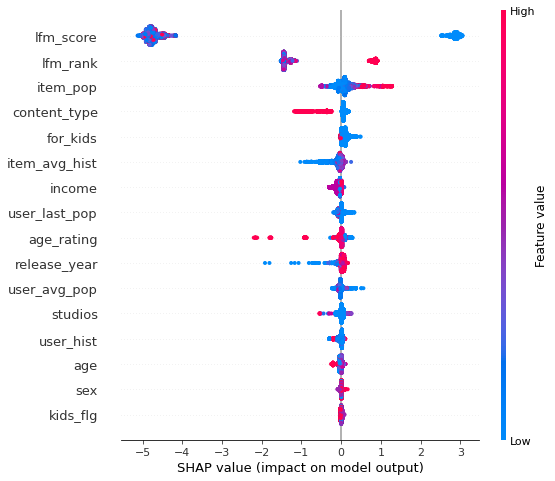

In [39]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

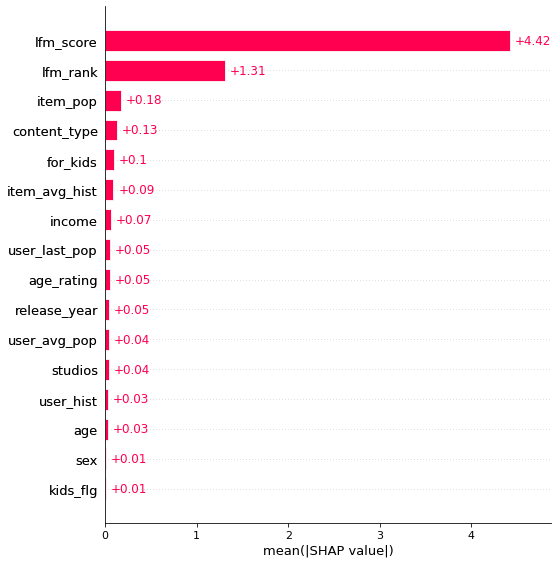

In [40]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))